# Conversion of Jump-start R program provided by Dr. Thomas Miller.

## Applied the Monte Carlo Simulation Method to a Personal ETF portfolio optimization problem. The Sharpe Ratio and target weights between the two schemes, Long Only and Shorts OK, have been compared

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

In [16]:
# Calculate covariance Matrix from given standard deviation and correlation matrix

def cov_from_sd_corr(sd, corr):
    """Build covariance matrix from SD vector and correlation matrix."""
    print(f"Input 1: SD array:\n {sd}")
    print(f"Input 2: Correlation Matrix:\n {corr}")
    D = np.diag(sd)
    print (f"Diagonal Matix D created from SD:\n {D}")
    print (f"first step calculate: D @ corr: \n {D @ corr}")
    return D @ corr @ D


In [19]:
def make_weights(n_assets=4, shorts_ok=True, rng=None):
    """Return a single weight vector that sums to 1.
       If shorts_ok True, generate 3 uniform(-1,1) and set 4th = 1 - sum(3).
       If shorts_ok False, generate uniform(0,1) and normalize.
    """
    if rng is None:
        rng = np.random
    if shorts_ok:
        three = rng.uniform(-1, 1, size=n_assets-1)
        fourth = 1.0 - three.sum()
        w = np.concatenate([three, [fourth]])
    else:
        raw = rng.uniform(0, 1, size=n_assets)
        w = raw / raw.sum()
    return w

In [20]:
def simulate_returns(mu, cov, sample_size=700, seed=None):
    """Simulate multivariate normal returns (sample_size x n_assets)."""
    rng = np.random.default_rng(seed)
    return rng.multivariate_normal(mean=mu, cov=cov, size=sample_size)

In [21]:
# calculate weights, mean, sd, sharpe ratio
# further add var_95, cvar_95 to see relationship with sharpe ratio later
def evaluate_portfolios(returns, weights_matrix, cov_matrix, rf=0.0):
    """Compute portfolio return series, mean, sd, Sharpe, CVaR (95) for each weight set."""
    n_portfolios = weights_matrix.shape[0]
    results = []
    # returns: (T, N); we'll compute port returns as returns @ w
    for i in range(n_portfolios):
        w = weights_matrix[i]
        port_returns = returns @ w  # shape (T,)
        mean_ret = port_returns.mean()
        sd_ret = port_returns.std(ddof=1)
        sharpe = (mean_ret - rf) / sd_ret if sd_ret > 0 else np.nan
        # VaR (5% quantile) and CVaR (average of losses <= VaR)
        var_95 = np.percentile(port_returns, 5)
        cvar_95 = port_returns[port_returns <= var_95].mean() if np.any(port_returns <= var_95) else var_95
        # theoretical sigma via w' Sigma w as cross-check
        theo_sd = np.sqrt(w.T @ cov_matrix @ w)
        results.append({
            "w1": w[0], "w2": w[1], "w3": w[2], "w4": w[3],
            "has_shorts": int(np.any(w < 0)),
            "mean": mean_ret,
            "sd_sample": sd_ret,
            "sd_theoretical": theo_sd,
            "sharpe": sharpe,
            "var_95": var_95,
            "cvar_95": cvar_95
        })
    return pd.DataFrame(results)

In [43]:
def run_experiment(mu, sd, corr, sample_size=700, n_weights=700, seed_returns=1111, seed_weights=9999):
    """Run Monte Carlo: simulate returns, generate weight sets (shorts and no-shorts),
       evaluate portfolios and return combined results for both regimes.
    """
    cov = cov_from_sd_corr(sd, corr)
    returns = simulate_returns(mu, cov, sample_size=sample_size, seed=seed_returns)  # (T,N)
    data_cov = np.cov(returns, rowvar=False)

    # generate weights
    rng = np.random.default_rng(seed_weights)
    weights_shorts = np.vstack([make_weights(4, shorts_ok=True, rng=rng) for _ in range(n_weights)])
    rng2 = np.random.default_rng(seed_weights)  # same seed to keep parallel structure
    weights_long = np.vstack([make_weights(4, shorts_ok=False, rng=rng2) for _ in range(n_weights)])

    # evaluate long only
    res_long = evaluate_portfolios(returns, weights_long, data_cov)
    res_long["regime"] = "Long Positions Only"

    # evaluate shorts ok
    res_shorts = evaluate_portfolios(returns, weights_shorts, data_cov)
    res_shorts["regime"] = "Shorts OK"

    # attach sample statistics
    sample_stats = {
        "returns_sim_mean": returns.mean(axis=0),
        "returns_sim_sd": returns.std(axis=0, ddof=1),
        "data_cov_matrix": data_cov
    }
    return pd.concat([res_long, res_shorts], ignore_index=True), sample_stats

In [71]:
def plot_results(df, title=None):
    df_plot = df.copy()
    df_plot["sd"] = df_plot["sd_sample"]
    df_plot["mean_return"] = df_plot["mean"]
    df_plot["short_flag"] = df_plot["has_shorts"].map({0:"No Shorts", 1:"Has Shorts"})
    print("Counts of short_flag within each regime:")
    print(df_plot.groupby("regime")["short_flag"].value_counts())
    # add scenario label from caller: caller should add 'scenario' column
    color_map = {"No Shorts": "darkblue", "Has Shorts": "red"}
    g = sns.FacetGrid(df_plot, row="scenario", col="regime", height=4, sharex=True, sharey=True)
    g.map_dataframe(sns.scatterplot, x="sd", y="mean_return", hue="short_flag", s=20, palette=color_map, alpha=0.7)
    g.set_axis_labels("Risk: Standard Deviation of Portfolio Returns", "Return: Mean of Portfolio Returns")
    if title:
        plt.subplots_adjust(top=0.9); g.fig.suptitle(title)
    return g

Input 1: SD array:
 [0.05 0.12 0.17 0.25]
Input 2: Correlation Matrix:
 [[1.  0.3 0.3 0.3]
 [0.3 1.  0.6 0.6]
 [0.3 0.6 1.  0.6]
 [0.3 0.6 0.6 1. ]]
Diagonal Matix D created from SD:
 [[0.05 0.   0.   0.  ]
 [0.   0.12 0.   0.  ]
 [0.   0.   0.17 0.  ]
 [0.   0.   0.   0.25]]
first step calculate: D @ corr: 
 [[0.05  0.015 0.015 0.015]
 [0.036 0.12  0.072 0.072]
 [0.051 0.102 0.17  0.102]
 [0.075 0.15  0.15  0.25 ]]
Counts of short_flag within each regime:
regime               short_flag
Long Positions Only  No Shorts     700
Shorts OK            Has Shorts    684
                     No Shorts      16
Name: count, dtype: int64


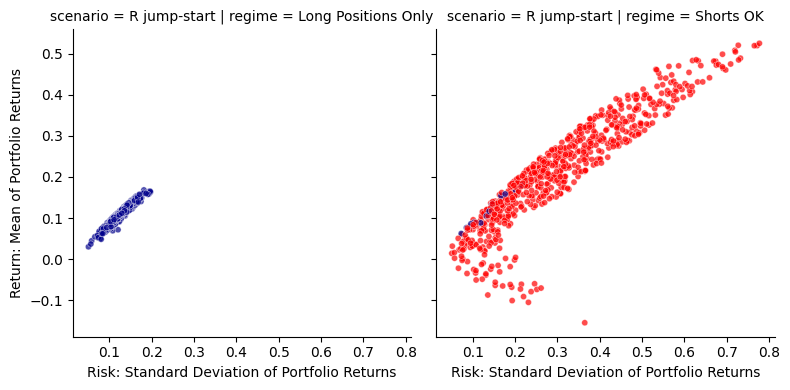

In [74]:
# -------------------------
# Scenario 1: R jump-start values (use exactly the R vectors)
# -------------------------
mu1 = np.array([0.02, 0.07, 0.15, 0.20])   # per-period means (as in the R starter)
sd1 = np.array([0.05, 0.12, 0.17, 0.25])
corr1 = np.array([
    [1.0, 0.3, 0.3, 0.3],
    [0.3, 1.0, 0.6, 0.6],
    [0.3, 0.6, 1.0, 0.6],
    [0.3, 0.6, 0.6, 1.0]
])
res1, stats1 = run_experiment(mu1, sd1, corr1, sample_size=700, n_weights=700, seed_returns=1111, seed_weights=9999)
res1["scenario"] = "R jump-start"
g = plot_results (res1)
g.savefig("portfolio_results_scenario1.png")

In [107]:
# -------------------------
# Scenario 2: Personal ETF
# -------------------------
import yfinance as yf

# choose tickers for your 4-asset portfolio (change as desired)
tickers = ["FXAIX", "QQQM", "SCHD", "SFLNX"]

# date range for estimating parameters (at least 5 years recommended)
start_date = "2025-01-01"
end_date = "2025-10-01"
# try downloading (auto_adjust=False so "Adj Close" may appear)
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=False)

# inspect columns if something unexpected happens
print("Column structure sample:", list(data.columns[:20]))

# robust extraction of adjusted close prices
if isinstance(data.columns, pd.MultiIndex):
    # prefer level=0='Adj Close' if present, else try level=1
    if 'Adj Close' in data.columns.levels[0]:
        prices = data.xs('Adj Close', axis=1, level=0).dropna()
    elif 'Adj Close' in data.columns.levels[1]:
        prices = data.xs('Adj Close', axis=1, level=1).dropna()
    else:
        # fallback to 'Close' fields
        if 'Close' in data.columns.levels[0]:
            prices = data.xs('Close', axis=1, level=0).dropna()
        else:
            # flatten and attempt to pick ticker columns
            flat = pd.DataFrame({ (col[-1] if isinstance(col, tuple) else col): data[col] for col in data.columns })
            prices = flat.loc[:, flat.columns.intersection(tickers)].dropna()
else:
    # single-level columns: might already be tickers or 'Adj Close' absent
    if set(tickers).issubset(data.columns):
        prices = data.loc[:, tickers].dropna()
    elif 'Adj Close' in data.columns:
        prices = data['Adj Close'].dropna()
    else:
        # try any column containing 'Close'
        close_cols = [c for c in data.columns if 'Close' in str(c)]
        if close_cols:
            prices = data[close_cols].dropna()
        else:
            raise RuntimeError("Could not locate price columns in downloaded data; inspect data.columns")

# normalize column names to tickers (handles tuples)
prices.columns = [c if not isinstance(c, tuple) else c[-1] for c in prices.columns]
print("Final price columns:", list(prices.columns))

# compute daily simple returns
daily_ret = prices.pct_change().dropna()

# trading days per year (use 252 for US markets)
trading_days = 252

# Option A: arithmetic annualization (common, simple)
mean_daily = daily_ret.mean()
mu_annual = mean_daily * trading_days        # approximate expected annual return
sd_daily = daily_ret.std(ddof=1)
sd_annual = sd_daily * np.sqrt(trading_days) # annualized volatility

# correlation matrix (use daily returns)
corr_matrix = daily_ret.corr()

# convert to numpy arrays used by the notebook functions
mu2 = mu_annual.to_numpy()
sd2 = sd_annual.to_numpy()
corr2 = corr_matrix.to_numpy()

# print/inspect
print("Estimated annualized means:", mu2.round(4))
print("Estimated annualized sds:", sd2.round(4))
print("Estimated correlation matrix:\n", corr2.round(3))

Column structure sample: [('Adj Close', 'FXAIX'), ('Adj Close', 'QQQM'), ('Adj Close', 'SCHD'), ('Adj Close', 'SFLNX'), ('Close', 'FXAIX'), ('Close', 'QQQM'), ('Close', 'SCHD'), ('Close', 'SFLNX'), ('High', 'FXAIX'), ('High', 'QQQM'), ('High', 'SCHD'), ('High', 'SFLNX'), ('Low', 'FXAIX'), ('Low', 'QQQM'), ('Low', 'SCHD'), ('Low', 'SFLNX'), ('Open', 'FXAIX'), ('Open', 'QQQM'), ('Open', 'SCHD'), ('Open', 'SFLNX')]
Final price columns: ['FXAIX', 'QQQM', 'SCHD', 'SFLNX']
Estimated annualized means: [0.2118 0.258  0.0557 0.1824]
Estimated annualized sds: [0.2052 0.2501 0.1743 0.1796]
Estimated correlation matrix:
 [[1.    0.977 0.772 0.949]
 [0.977 1.    0.657 0.875]
 [0.772 0.657 1.    0.907]
 [0.949 0.875 0.907 1.   ]]


In [106]:
res2, stats2 = run_experiment(mu2, sd2, corr2,
                              sample_size=700, n_weights=700,
                              seed_returns=2222, seed_weights=8888)

Input 1: SD array:
 [0.2051862  0.25006289 0.17431979 0.17960399]
Input 2: Correlation Matrix:
 [[1.         0.9769439  0.7717889  0.94907898]
 [0.9769439  1.         0.65702711 0.87500503]
 [0.7717889  0.65702711 1.         0.90652282]
 [0.94907898 0.87500503 0.90652282 1.        ]]
Diagonal Matix D created from SD:
 [[0.2051862  0.         0.         0.        ]
 [0.         0.25006289 0.         0.        ]
 [0.         0.         0.17431979 0.        ]
 [0.         0.         0.         0.17960399]]
first step calculate: D @ corr: 
 [[0.2051862  0.2004554  0.15836043 0.19473791]
 [0.24429741 0.25006289 0.1642981  0.21880629]
 [0.13453808 0.11453283 0.17431979 0.15802486]
 [0.17045837 0.15715439 0.16281511 0.17960399]]


Counts of short_flag within each regime:
regime               short_flag
Long Positions Only  No Shorts     700
Shorts OK            Has Shorts    685
                     No Shorts      15
Name: count, dtype: int64


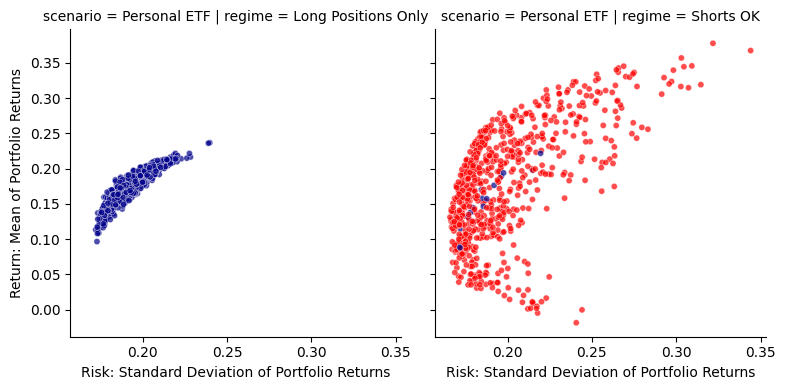

In [108]:
res2["scenario"] = "Personal ETF"
g = plot_results (res2)
g.savefig("portfolio_results_scenario2.png")

In [80]:
print("Top 10 portfolios by Sharpe Ratio:")
display(res2.sort_values(by="sharpe", ascending=False).head(10))

Top 10 portfolios by Sharpe Ratio:


,w1,w2,w3,w4,has_shorts,mean,sd_sample,sd_theoretical,sharpe,var_95,cvar_95,regime,scenario
1395,-0.780250,-0.036712,-0.998574,2.815535,1,0.278473,0.195363,0.195363,1.425408,-0.041741,-0.143353,Shorts OK,Personal ETF
828,0.190958,-0.516908,-0.991734,2.317684,1,0.269246,0.191173,0.191173,1.408389,-0.045863,-0.143238,Shorts OK,Personal ETF
1026,-0.866572,0.506471,-0.978667,2.338767,1,0.311581,0.222932,0.222932,1.397649,-0.048804,-0.158110,Shorts OK,Personal ETF
1276,-0.038757,-0.292421,-0.916993,2.248172,1,0.269863,0.193908,0.193908,1.391707,-0.055253,-0.147318,Shorts OK,Personal ETF
1214,-0.781883,0.319128,-0.875067,2.337821,1,0.288159,0.208276,0.208276,1.383543,-0.057534,-0.155808,Shorts OK,Personal ETF
1226,-0.249787,0.021096,-0.885801,2.114492,1,0.282435,0.204510,0.204510,1.381030,-0.050134,-0.154524,Shorts OK,Personal ETF
831,0.497356,-0.708978,-0.945288,2.156911,1,0.258138,0.187090,0.187090,1.379751,-0.049917,-0.146448,Shorts OK,Personal ETF
713,-0.508512,-0.237271,-0.897114,2.642896,1,0.259202,0.188433,0.188433,1.375567,-0.058296,-0.149355,Shorts OK,Personal ETF
1387,-0.798934,-0.061426,-0.878578,2.738938,1,0.261703,0.190268,0.190268,1.375445,-0.061255,-0.150290,Shorts OK,Personal ETF
974,-0.343432,-0.030557,-0.849434,2.223423,1,0.272021,0.197894,0.197894,1.374578,-0.055121,-0.152841,Shorts OK,Personal ETF


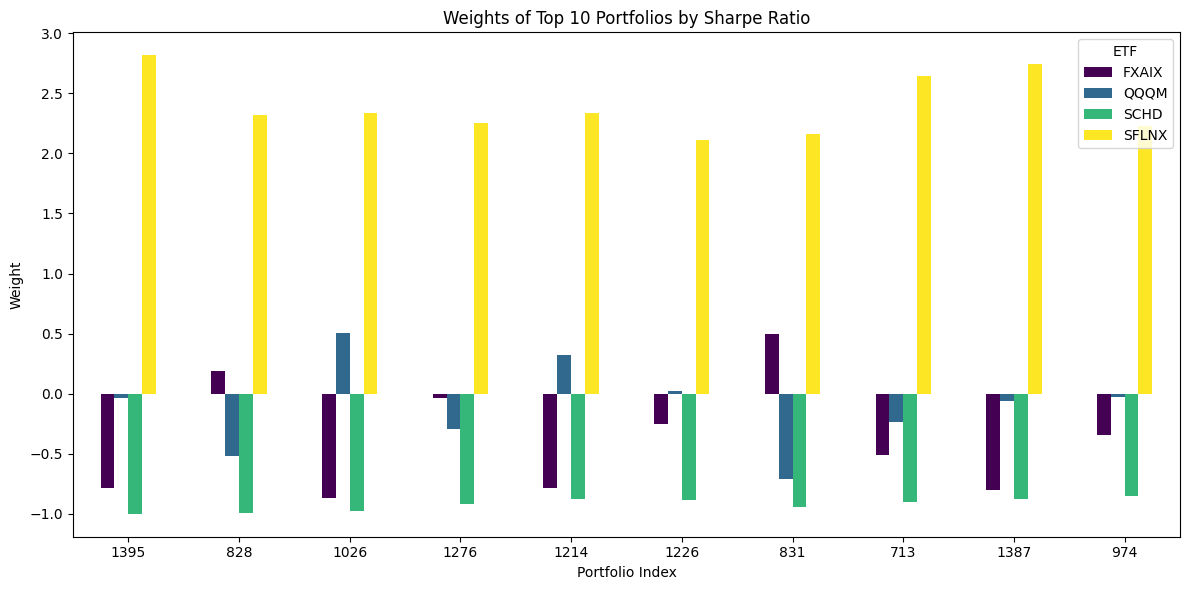

In [82]:
import matplotlib.pyplot as plt

top_10_portfolios = res2.sort_values(by="sharpe", ascending=False).head(10)

# Select only the weight columns
weights_df = top_10_portfolios[['w1', 'w2', 'w3', 'w4']]

# Rename columns for better plotting labels
weights_df.columns = ["FXAIX", "QQQM", "SCHD", "SFLNX"]

# Plotting the weights
ax = weights_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')

plt.title('Weights of Top 10 Portfolios by Sharpe Ratio')
plt.xlabel('Portfolio Index')
plt.ylabel('Weight')
plt.xticks(rotation=0)
plt.legend(title='ETF')
plt.tight_layout()
plt.show()

In [86]:
# Assuming the 700 simulation periods represent 700 trading days
sim_periods = 700
trading_days_in_year = 252

# Calculate annualized mean returns for each portfolio in res2
res2["mean_annualized_simulated"] = res2["mean"] * (trading_days_in_year / sim_periods)

print("Simulated Mean Returns (over 700 periods) vs. Annualized Simulated Mean Returns:")
display(res2[["mean", "mean_annualized_simulated"]].head())

# Optionally, you can also display the top portfolios with their annualized simulated returns
print("\nTop 10 portfolios by  Annualized Simulated Mean Return:")
display(res2.sort_values(by="mean", ascending=False).head(10)[["w1", "w2", "w3", "w4", "mean", "mean_annualized_simulated", "sharpe"]])

Simulated Mean Returns (over 700 periods) vs. Annualized Simulated Mean Returns:


,mean,mean_annualized_simulated
0,0.141002,0.050761
1,0.188934,0.068016
2,0.180525,0.064989
3,0.157688,0.056768
4,0.158145,0.056932



Top 10 portfolios by Sharpe Ratio with Annualized Simulated Mean Return:


,w1,w2,w3,w4,mean,mean_annualized_simulated,sharpe
1206,0.405474,0.951902,-0.999030,0.641653,0.377716,0.135978,1.173855
877,0.989105,0.984663,-0.772103,-0.201665,0.367442,0.132279,1.067711
1238,0.428277,0.819841,-0.898599,0.650482,0.356929,0.128495,1.177882
807,0.978894,0.675591,-0.771882,0.117397,0.345675,0.124443,1.117731
1056,-0.223208,0.750166,-0.980438,1.453480,0.345274,0.124299,1.284283
873,0.826572,0.703210,-0.778630,0.248849,0.344497,0.124019,1.131148
858,0.041182,0.582087,-0.999363,1.376094,0.342691,0.123369,1.289415
1111,-0.528131,0.876444,-0.929473,1.581161,0.340019,0.122407,1.285589
924,0.489345,0.830955,-0.736605,0.416305,0.339600,0.122256,1.138477
757,0.755265,0.239629,-0.994873,0.999980,0.336710,0.121216,1.267908


In [91]:
# Detect the points that make the Efficient Frontier for the Portfolio
efficient_frontier_portfolios_list = []

for i in range(len(res2)):
  is_on_frontier = True
  portfolio_to_check = res2.iloc[i]

  for j in range(len(res2)):
      if i != j:
          other_portfolio = res2.iloc[j]
          # Check if other_portfolio dominates portfolio_to_check
          if (other_portfolio["sd_sample"] <= portfolio_to_check["sd_sample"] and other_portfolio["mean"] > portfolio_to_check["mean"]) or \
            (other_portfolio["sd_sample"] < portfolio_to_check["sd_sample"] and other_portfolio["mean"] >= portfolio_to_check["mean"]):
              is_on_frontier = False
              break

  if is_on_frontier:
      # If on the frontier, add the portfolio (as a Series or dictionary) to the list
      efficient_frontier_portfolios_list.append(portfolio_to_check)
      #print(f"Portfolio at index {i} is on the simulated efficient frontier.")
  #else:
  #    print(f"Portfolio at index {i} is NOT on the simulated efficient frontier.")

# Convert the list of efficient frontier portfolios into a DataFrame
ef_frame = pd.DataFrame(efficient_frontier_portfolios_list)


print("Efficient Frontier Portfolios:")
display(ef_frame)


Efficient Frontier Portfolios:


,w1,w2,w3,w4,has_shorts,mean,sd_sample,sd_theoretical,sharpe,var_95,cvar_95,regime,scenario,mean_annualized_simulated
713,-0.508512,-0.237271,-0.897114,2.642896,1,0.259202,0.188433,0.188433,1.375567,-0.058296,-0.149355,Shorts OK,Personal ETF,0.093313
729,0.840741,-0.781615,0.040925,0.899949,1,0.142154,0.166530,0.166530,0.853628,-0.124920,-0.209627,Shorts OK,Personal ETF,0.051176
738,0.758722,-0.968235,-0.982545,2.192058,1,0.251367,0.183710,0.183710,1.368285,-0.048063,-0.147305,Shorts OK,Personal ETF,0.090492
760,0.093895,-0.602995,-0.837082,2.346182,1,0.241987,0.182339,0.182339,1.327128,-0.053651,-0.153965,Shorts OK,Personal ETF,0.087115
793,0.771675,-0.264701,-0.977044,1.470070,1,0.299921,0.221222,0.221222,1.355745,-0.041968,-0.165116,Shorts OK,Personal ETF,0.107971
798,-0.409103,0.511029,-0.974809,1.872883,1,0.323193,0.239128,0.239128,1.351547,-0.051983,-0.170390,Shorts OK,Personal ETF,0.116349
805,0.125748,-0.568128,-0.901650,2.344030,1,0.253070,0.185447,0.185447,1.364653,-0.051858,-0.148808,Shorts OK,Personal ETF,0.091105
809,0.147638,-0.562618,-0.827253,2.242233,1,0.244982,0.183551,0.183551,1.334677,-0.059208,-0.152839,Shorts OK,Personal ETF,0.088193
815,-0.845298,0.945457,-0.833716,1.733557,1,0.325031,0.252303,0.252303,1.288257,-0.078524,-0.187631,Shorts OK,Personal ETF,0.117011
828,0.190958,-0.516908,-0.991734,2.317684,1,0.269246,0.191173,0.191173,1.408389,-0.045863,-0.143238,Shorts OK,Personal ETF,0.096929


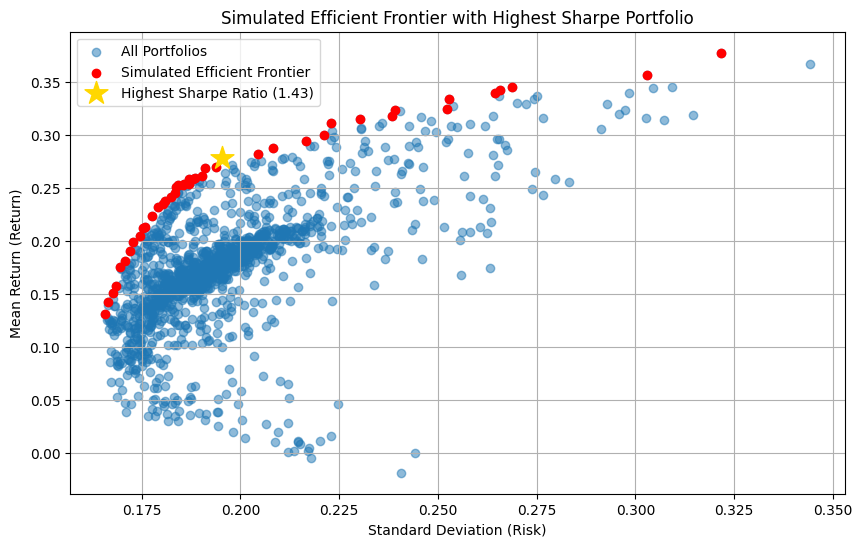

In [104]:
# Plot the efficient frontier portfolios
if not ef_frame.empty:
    plt.figure(figsize=(10, 6))
    plt.scatter(res2["sd_sample"], res2["mean"], label="All Portfolios", alpha=0.5)
    plt.scatter(ef_frame["sd_sample"], ef_frame["mean"], color='red', label="Simulated Efficient Frontier", zorder=5)

    # Find the portfolio with the highest Sharpe Ratio
    highest_sharpe_portfolio = res2.loc[res2["sharpe"].idxmax()]

    # Highlight the highest Sharpe Ratio portfolio
    plt.scatter(
        highest_sharpe_portfolio["sd_sample"],
        highest_sharpe_portfolio["mean"],
        color='gold',       # Distinct color
        marker='*',         # Star marker
        s=300,              # Larger size
        label=f'Highest Sharpe Ratio ({highest_sharpe_portfolio["sharpe"]:.2f})',
        zorder=10           # Ensure it's on top
    )

    plt.xlabel("Standard Deviation (Risk)")
    plt.ylabel("Mean Return (Return)")
    plt.title("Simulated Efficient Frontier with Highest Sharpe Portfolio")
    plt.legend()
    plt.grid(True)
    plt.savefig("sharpe_ratio_ef.png")
    plt.show()

In [112]:
# save ef_frame to csv for further analysis
ef_frame.to_csv("efficient_frontier_portfolios.csv", index=False)

In [113]:
# Select the relevant columns from the efficient frontier DataFrame
metrics_df = ef_frame[["sharpe", "var_95", "cvar_95"]]

# Calculate the correlation matrix
correlation_matrix = metrics_df.corr()

print("Correlation Matrix between Sharpe Ratio, VaR (95%), and CVaR (95%) for Efficient Frontier Portfolios:")
display(correlation_matrix)

Correlation Matrix between Sharpe Ratio, VaR (95%), and CVaR (95%) for Efficient Frontier Portfolios:


,sharpe,var_95,cvar_95
sharpe,1.000000,0.926806,0.677499
var_95,0.926806,1.000000,0.836376
cvar_95,0.677499,0.836376,1.000000


In [114]:
# Find the portfolio with the highest Sharpe Ratio in the "Long Positions Only" regime
highest_sharpe_long_only = res2[res2["regime"] == "Long Positions Only"].loc[res2[res2["regime"] == "Long Positions Only"]["sharpe"].idxmax()]

print("Highest Sharpe Ratio Portfolio (Long Positions Only Regime):")
display(highest_sharpe_long_only[["w1", "w2", "w3", "w4", "sharpe", "mean", "sd_sample"]])

print("\nHighest Sharpe Ratio Portfolio (Shorts OK Regime):")
# We already found this one earlier, but let's display it again for easy comparison
highest_sharpe_shorts_ok = res2.loc[res2["sharpe"].idxmax()]
display(highest_sharpe_shorts_ok[["w1", "w2", "w3", "w4", "sharpe", "mean", "sd_sample"]])

# You can also display the weights side-by-side in a DataFrame for easier comparison
comparison_df = pd.DataFrame([highest_sharpe_long_only[["w1", "w2", "w3", "w4"]], highest_sharpe_shorts_ok[["w1", "w2", "w3", "w4"]]])
comparison_df.index = ["Long Positions Only", "Shorts OK"]
comparison_df.columns = ["FXAIX", "QQQM", "SCHD", "SFLNX"]

print("\nComparison of Weights for Highest Sharpe Ratio Portfolios:")
display(comparison_df)

Highest Sharpe Ratio Portfolio (Long Positions Only Regime):


,560
w1,0.301802
w2,0.20992
w3,0.001031
w4,0.487247
sharpe,1.017475
mean,0.202043
sd_sample,0.198573



Highest Sharpe Ratio Portfolio (Shorts OK Regime):


,1395
w1,-0.78025
w2,-0.036712
w3,-0.998574
w4,2.815535
sharpe,1.425408
mean,0.278473
sd_sample,0.195363



Comparison of Weights for Highest Sharpe Ratio Portfolios:


,FXAIX,QQQM,SCHD,SFLNX
Long Positions Only,0.301802,0.209920,0.001031,0.487247
Shorts OK,-0.780250,-0.036712,-0.998574,2.815535
